# Advanced NLP HW0

Before starting the task please read thoroughly these chapters of Speech and Language Processing by Daniel Jurafsky & James H. Martin:

•	N-gram language models: https://web.stanford.edu/~jurafsky/slp3/3.pdf

•	Neural language models: https://web.stanford.edu/~jurafsky/slp3/7.pdf 

In this task you will be asked to implement the models described there.

Build a text generator based on n-gram language model and neural language model.
1.	Find a corpus (e.g. http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt ), but you are free to use anything else of your interest
2.	Preprocess it if necessary (we suggest using nltk for that)
3.	Build an n-gram model
4.	Try out different values of n, calculate perplexity on a held-out set
5.	Build a simple neural network model for text generation (start from a feed-forward net for example). We suggest using tensorflow + keras for this task

Criteria:
1.	Data is split into train / validation / test, motivation for the split method is given
2.	N-gram model is implemented
a.	Unknown words are handled
b.	Add-k Smoothing is implemented
3.	Neural network for text generation is implemented
4.	Perplexity is calculated for both models
5.	Examples of texts generated with different models are present and compared
6.	Optional: Try both character-based and word-based approaches.

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

import re
import urllib.request as urllib2

from collections import defaultdict
import random

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline, padded_everygrams
from nltk.lm import MLE, Vocabulary, KneserNeyInterpolated, WittenBellInterpolated, Laplace, Lidstone



from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split

In [98]:
data = list(urllib2.urlopen('https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'))

In [99]:
def preproc(data):
    data = [line.strip().decode("utf-8")  for line in data]
    pat = re.compile(r'((\b\w*)|(\b\w*\s?\b\w*)):$')
    data = [i.lower() for i in data if i]
    p = []
    speech = ''
    for line in data:
        if not pat.findall(line):
            if not speech:
                speech = line
            else:
                speech += ' ' + line

        else:
            p.append(speech)
            speech = ''
    p = [string for string in p if len(string) != 0]
    
    return p

In [100]:
data = preproc(data)

In [101]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"im" :"I am",
"isn't" : "is not",
"its": "it is",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"won't":"will not",
"didn't": "did not",
"'t'": ' it', 
"'em": "them",
"o'": "of", 
"'ll": " will",
"ne'er":"never",
"'ld": " would", "i'": "in",
"'d": "ed", 
"'en ": "ken ", 
"'bout":"about", 
"'gainst":"against", 
"'scape":"escape", 
"'mongst": "amongst", 
"'n": "en", 
"e'er":"ever", 
"itwas":"it was"
}
for i, j in appos.items():
    for k in range(len(data)):
        data[k] = data[k].replace(i, j)   

In [102]:
tokenized = list(map(nltk.word_tokenize, data))

In [103]:
tokenized[0:4]

[['before',
  'we',
  'proceed',
  'any',
  'further',
  ',',
  'hear',
  'me',
  'speak',
  '.'],
 ['speak', ',', 'speak', '.'],
 ['you',
  'are',
  'all',
  'resolved',
  'rather',
  'to',
  'die',
  'than',
  'to',
  'famish',
  '?'],
 ['resolved', '.', 'resolved', '.']]

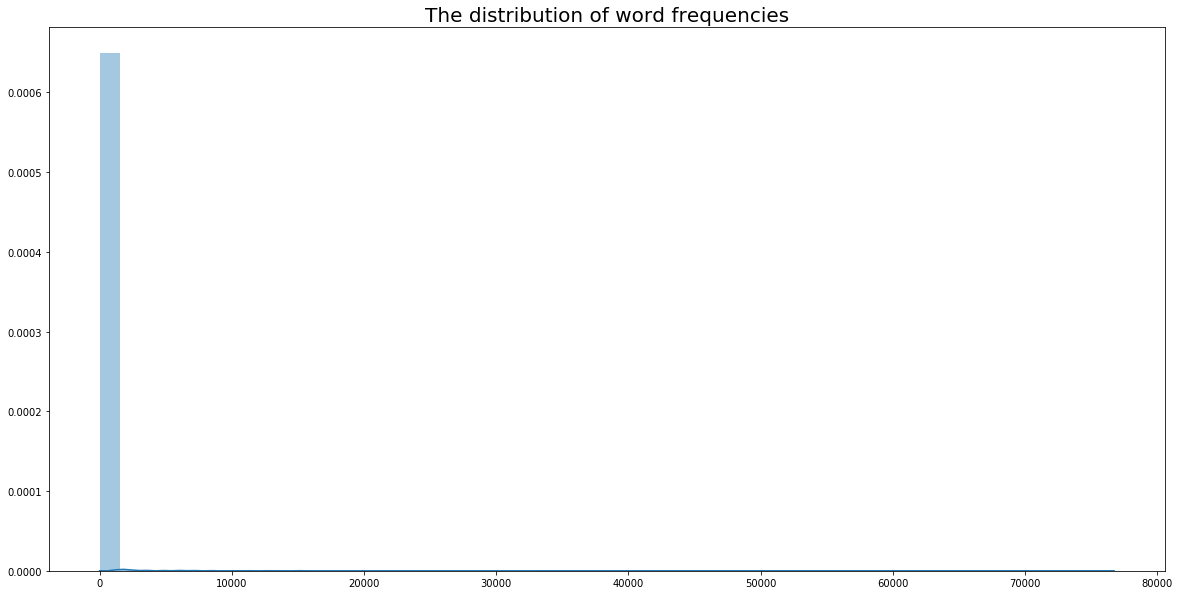

In [104]:
plt.figure(figsize=(20,10))
sns.distplot(pd.Series([item for speech in tokenized for item in speech]).value_counts())
plt.title('The distribution of word frequencies', fontsize=20)
plt.show()

## Models

Base class for the model.

In [115]:
X_train, X_test = train_test_split(tokenized, test_size=0.01, random_state=42)

In [118]:
X_test = [item for speech in X_test for item in speech]

In [119]:
X_test

['speak',
 ',',
 'brave',
 'hector',
 ':',
 'we',
 'are',
 'much',
 'delighted',
 '.',
 'heard',
 'he',
 'the',
 'good',
 'news',
 'yet',
 '?',
 'tell',
 'it',
 'hI',
 'am',
 '.',
 'i',
 'marvel',
 'i',
 'hear',
 'not',
 'of',
 'master',
 'brook',
 ';',
 'he',
 'sent',
 'me',
 'word',
 'to',
 'stay',
 'within',
 ':',
 'i',
 'like',
 'his',
 'money',
 'well',
 '.',
 'o',
 ',',
 'here',
 'he',
 'comes',
 '.',
 'these',
 'are',
 'not',
 'natural',
 'events',
 ';',
 'they',
 'strengthen',
 'from',
 'strange',
 'to',
 'stranger',
 '.',
 'say',
 ',',
 'how',
 'came',
 'you',
 'hither',
 '?',
 'in',
 'faith',
 ',',
 'they',
 'are',
 'as',
 'true',
 'of',
 'heart',
 'as',
 'we',
 '.',
 'my',
 'father',
 'had',
 'a',
 'daughter',
 'loved',
 'a',
 'man',
 ',',
 'as',
 'it',
 'might',
 'be',
 ',',
 'perhaps',
 ',',
 'were',
 'i',
 'a',
 'woman',
 ',',
 'i',
 'should',
 'your',
 'lordship',
 '.',
 'a',
 'witch',
 ',',
 'a',
 'quean',
 ',',
 'an',
 'old',
 'cozening',
 'quean',
 '!',
 'have',
 'i',

In [123]:
class BaseLM:
    
    def __init__(self, n, gamma, vocab = None):
    
        """Language model constructor
        n -- n-gram size
        vocab -- optional fixed vocabulary for the model
        """
        self.n = n
        self.vocab = vocab
        self.corpus = []
        self.dic = defaultdict(lambda: defaultdict(lambda: 0))
        self.gamma = gamma
        self.generate_corpus()
        
    def generate_corpus(self):
        
        """
        The formula for add-k smoothing is:

        p(w_i|w_i-1) = (c(w_i-1, w-i) + k) / (c(w_i-1) + k*V),

        where V is the number of unique  words in the vocabulary

        """
      
        rare_words = pd.Series([item for speech in self.vocab for item in speech]).value_counts()[(pd.Series([item for speech in self.vocab for item in speech]).value_counts() < 2)].index.tolist()
        rare_words_dict = {k: "<UNK>" for  k in rare_words}
        self.vocab_unk = [list(map(lambda x: rare_words_dict[x] if x in rare_words_dict.keys() else x, [item for item in speech])) for speech in self.vocab]
            
        for speech in self.vocab_unk:

            ngram = nltk.ngrams([word for word in speech], self.n, pad_right=True, pad_left=True)
            self.corpus.append(list(ngram))

        N = len([item for speech in self.corpus for item in speech])
        V = len(set([item for speech in self.vocab_unk for item in speech]))
            
        for ngram in [item for sublist in self.corpus for item in sublist]:
            self.dic[(ngram[:-1])][ngram[-1]] += 1

        for key in self.dic.keys():
            total = float(sum(self.dic[key].values()))
            for value in self.dic[key]:
                self.dic[key][value] = (self.dic[(key)][value] + self.gamma) / (total + self.gamma*V)


        print("The length of the vocabulary is {}".format(V))
        print("The number of the {}-grams is {}".format(self.n, N))

             

    def prob(self, word, context=None):
        """This method returns probability of a word with given context: P(w_t | w_{t - 1}...w_{t - n + 1})

        For example:
        >>> lm.prob('hello', context=('world',))
        0.99988
        """
        V = len(set([item for speech in self.vocab_unk for item in speech]))
        if word in self.dic[tuple(context.split(' '))].keys():
            print(self.dic[tuple(context.split(' '))][word])
        elif "<UNK>" in self.dic[key].keys():
            print(self.dic[tuple(context.split(' '))]["<UNK>"])
        else:
            total = float(sum(self.dic[key].values()))
            print((self.gamma) / (total + self.gamma*V))
 
    def generate_text(self, text_length):
        """This method generates random text of length 

        For example
        >>> lm.generate_text(2)
        hello world

        """
        text = list(list(self.dic.keys())[random.randint(0, len(self.dic))])
        scaler = StandardScaler()
        
        while len(text)<=text_length:
  
            probs = scaler.fit_transform(np.array(list(self.dic[tuple(text[-(self.n-1):])].values())).reshape(-1, 1))
            probs = softmax(probs).reshape(-1)
            new_word = np.random.choice(list(self.dic[tuple(text[-(self.n-1):])].keys()), p=probs)
            text.append(new_word)
                
        for ind, word in enumerate(text):
            if ind % 10 == 0:
                text.insert(ind, "\n")
            
        text_to_display = ' '.join([w for w in text if w])
        for mark in re.findall(r"\s[.;:,!?\\']", text_to_display):
            text_to_display= text_to_display.replace(mark, mark[-1:])
        
        print(text_to_display)
                

    def update(self, sequence_of_tokens):
        """This method learns probabiities based on given sequence of tokents

        sequence_of_tokens -- iterable of tokens

        For example
        >>> lm.update(['hello', 'world'])
        """
        self.vocab.extend(sequence_of_tokens)
        self.generate_corpus()
        
        
    
    def perplexity(self, sequence_of_tokens):
        """This method returns perplexity for a given sequence of tokens

        sequence_of_tokens -- iterable of tokens
        """
        
        
        

In [112]:
blm = BaseLM(4, 0.0001, X_train)

The length of the vocabulary is 14427
The number of the 4-grams is 1015891


In [113]:
blm.prob('betide', "i will rest")

5.399206538336337e-05


In [114]:
blm.generate_text(200)


 my purposes, or if that thou be'st a 
 roman, take it. i 
 am the best of them were hereditary hangmen. 
 god-den to your worship. i 
 am a gentleman. i am 
 a gentleman? let <UNK> and <UNK>, and 
 that is mine. i am 
 not <UNK> and rash, yet have i left 
 a daughter. i am thus 
 encountered with <UNK> demands of <UNK> bonds, and 
 the <UNK> of the <UNK>, and <UNK>, 
 and <UNK>; and i will overhear their conference 
. if she be black and witty? 
 i am glad to clasp thee. 
 i am sorry? so children 
 temporal fathers do appease; gods are more full 
 of mercy. i have dogged hI am, 
 and i will give treason his payment into <UNK> 
, as i am, and i will take 
 thee too. i am not 
 a word? ay, or I will unpeople 
 egypt. i am sorry for 
 your displeasure;


In [69]:
pow(2, (np.log(0.0006981413853729772)* 0.0006981413853729772))

0.9964895247838892

In [ ]:
float(blm.dic[key][word].value())

In [130]:
for key in blm.dic.keys():
    
            '''for word in key:
                total = float(blm.dic[key][word])
                blm.dic[(key)][word] = total/k'''

KeyboardInterrupt: 

In [108]:
blm.dic

defaultdict(<function __main__.BaseLM.__init__.<locals>.<lambda>()>,
            {(None,): defaultdict(<function __main__.BaseLM.__init__.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'before': 19,
                          'speak': 57,
                          'you': 669,
                          'resolved': 1,
                          'first': 41,
                          'we': 290,
                          'let': 333,
                          'no': 629,
                          'one': 62,
                          'would': 58,
                          'against': 9,
                          'consider': 9,
                          'very': 45,
                          'nay': 355,
                          'i': 2813,
                          'what': 1170,
                          'if': 559,
                          'come': 371,
                          'soft': 16,
                          'worthy': 13,
                          'he': 584,
            

In [59]:
blm.undic[()]['']

0.0007041395425573097

In [131]:
data

['before we proceed any further, hear me speak.',
 'speak, speak.',
 'you are all resolved rather to die than to famish?',
 'resolved. resolved.',
 'first, you know caius marcius is chief enemy to the people.',
 "we know't, we know't.",
 "let us kill hI am, and  will have corn at our own price. is't a verdict?",
 "no more talking on't; let it be done: away, away!",
 'one word, good citizens.',
 'we are accounted poor citizens, the patricians good. what authority surfeit is on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely; but they think we are too dear: the leanness that afflicts us, the object of our misery, is as an inventory to particularise their abundance; our sufferance is a gain to them let us revenge this with our pikes, ere we become rakes: for the gods know i speak this in hunger for bread, not in thirst for revenge.',
 'would you proceed especially against caius marcius?',
 'against hI am first

In [26]:
blm.generate_text(100)


 unbuckle, unbuckle. fortunate mistress, thunder shall 
 not long ago. this bald <UNK> chat of 
 his blind fortune, she misused me past the 
 hope of great priamus. i wasted tI ame 
 let this count. all friends? and we 
 petty men walk under his muffler. 
 i heard your praises; who came in foot 
 and hand both open and apparent shame? 
 if fortune please, that hath enraged hI 
 am be furnished to inform you of something, 
 nothing afeard of the ignorant, call our own 
 wings,


In [24]:
blm.prob('we', 'before')

0.0009239704329461457


In [23]:
blm.prob('no', 'you are')

0
